In [1]:
import os

import torch
import torch.nn as nn

os.environ["TORCH"] = torch.__version__

In [2]:
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(
    root="./data/Planetoid", name="PubMed", transform=NormalizeFeatures()
)

In [3]:
print()
print(f"Dataset: {dataset}:")
print("==================")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

data = dataset[0]  # Get the first graph object.

print()
print(data)
print("====================================================")

# Gather some statistics about the graph.
print(f"Number of nodes: {data.num_nodes}")
print(f"Number of edges: {data.num_edges}")
print(f"Average node degree: {data.num_edges / data.num_nodes:.2f}")
print(f"Number of training nodes: {data.train_mask.sum()}")
print(f"Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.3f}")
print(f"Has isolated nodes: {data.has_isolated_nodes()}")
print(f"Has self-loops: {data.has_self_loops()}")
print(f"Is undirected: {data.is_undirected()}")


Dataset: PubMed():
Number of graphs: 1
Number of features: 500
Number of classes: 3

Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
Number of nodes: 19717
Number of edges: 88648
Average node degree: 4.50
Number of training nodes: 60
Training node label rate: 0.003
Has isolated nodes: False
Has self-loops: False
Is undirected: True


首先根据图分割算法将图分割成子图。这样，GNN 就只能在其特定的子图内卷积，从而避免了邻域爆炸的问题。

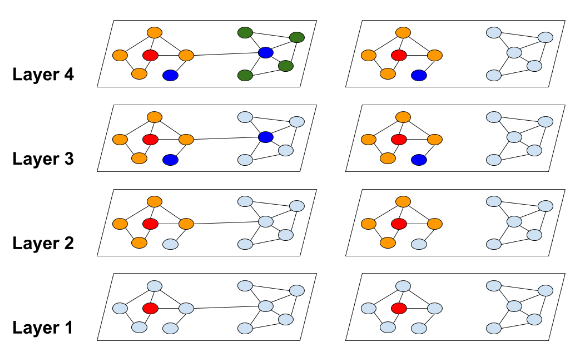

但是，在对图进行分区后，一些链接会被移除，这可能会因估计偏差而限制模型的性能。为解决这一问题，Cluster-GCN 还将簇间链接纳入了迷你批次，从而产生了以下随机分区方案：
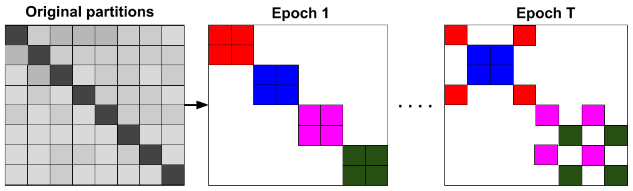

在这里，颜色代表每个批次维护的邻接信息（每个历时都可能不同）。

PyTorch Geometric 提供了 Cluster-GCN 算法的两阶段实现：
1. ClusterData 将数据对象转换为包含 num_parts 分区的子图数据集。
2. 给定用户定义的 batch_size，ClusterLoader 会执行随机分区方案，以创建mini-batch。
创建mini-batch的过程如下：

In [4]:
from torch_geometric.loader import ClusterData, ClusterLoader

In [5]:
torch.manual_seed(12345)
cluster_data = ClusterData(data, num_parts=128)  # 创建子图
train_loader = ClusterLoader(cluster_data, batch_size=32, shuffle=True)

Computing METIS partitioning...
Done!


In [13]:
print(cluster_data.num_parts)
print(cluster_data.data)
print(type(cluster_data))

128
Data(x=[19717, 500], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])
<class 'torch_geometric.loader.cluster.ClusterData'>


dgl中的mini-batch [GML_learning/DGL_learning/5. Training a GNN for Graph Classification.ipynb](../DGL_learning/5.&#32Training&#32a&#32GNN&#32for&#32Graph&#32Classification.ipynb)



In [7]:
total_num_nodes = 0
total_num_edges = 0
for step, sub_data in enumerate(train_loader):
    print(step)
    print("num of nodes in the current batch", sub_data.num_nodes)
    print(sub_data)
    total_num_nodes += sub_data.num_nodes
    total_num_edges += sub_data.num_edges
print()
print(type(sub_data))  # sub_data 就是data类型
print()
print("total_num_nodes", total_num_nodes, "和原图一样")
print("total_num_edges", total_num_edges, "原图88648，少了")

0
num of nodes in the current batch 4916
Data(x=[4916, 500], y=[4916], train_mask=[4916], val_mask=[4916], test_mask=[4916], edge_index=[2, 16180])
1
num of nodes in the current batch 4909
Data(x=[4909, 500], y=[4909], train_mask=[4909], val_mask=[4909], test_mask=[4909], edge_index=[2, 15912])
2
num of nodes in the current batch 4941
Data(x=[4941, 500], y=[4941], train_mask=[4941], val_mask=[4941], test_mask=[4941], edge_index=[2, 15958])
3
num of nodes in the current batch 4951
Data(x=[4951, 500], y=[4951], train_mask=[4951], val_mask=[4951], test_mask=[4951], edge_index=[2, 18662])

<class 'torch_geometric.data.data.Data'>

total_num_nodes 19717 和原图一样
total_num_edges 66712 原图88648，少了


In [8]:
# GCN
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(500, 16)
  (conv2): GCNConv(16, 3)
)


In [50]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [51]:
sub_data.keys()

['train_mask', 'x', 'y', 'test_mask', 'edge_index', 'val_mask']

In [52]:
def train():
    model.train()
    for sub_data in train_loader:  # 对每一个mini-batch
        optimizer.zero_grad()
        out = model(sub_data.x, sub_data.edge_index)
        loss = criterion(out[sub_data.train_mask], sub_data.y[sub_data.train_mask])
        loss.backward()
        optimizer.step()


def test():
    model.eval()
    pred = model(data.x, data.edge_index).argmax(1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask] == data.y[mask]
        accs.append((correct.sum() / mask.sum()).item())
    return accs

In [53]:
for epoch in range(1, 51):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 10 ==0:
        print(
            f"Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}"
        )

Epoch: 010, Train: 0.6667, Val Acc: 0.5320, Test Acc: 0.5240
Epoch: 020, Train: 0.9667, Val Acc: 0.7720, Test Acc: 0.7640
Epoch: 030, Train: 0.9833, Val Acc: 0.7900, Test Acc: 0.7790
Epoch: 040, Train: 0.9833, Val Acc: 0.8020, Test Acc: 0.7900
Epoch: 050, Train: 0.9833, Val Acc: 0.7940, Test Acc: 0.7940


本章介绍了将 GNN 扩展到大型图形的方法，否则 GPU 内存将无法容纳这些图形。
